In [1]:
import numpy as np

import torch
import torch.nn.functional as F

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import random

from mnist import MNIST

In [2]:
# GPU 설정(GPU가 있으면 GPU 사용, 없으면 cpu 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


## Data

In [3]:
# load data
mnist = MNIST('../../Deeplearning_dataset/MNIST/raw')
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

In [4]:
# preprocessing
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [5]:
# train shape
x_train.shape

(60000, 784)

In [6]:
# test.shape
x_test.shape

(10000, 784)

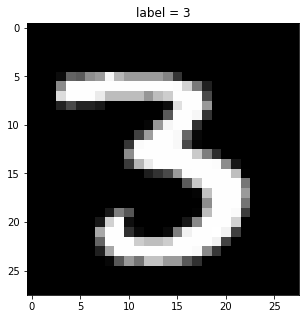

In [7]:
# data visualization
data_idx = 12
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(np.array(x_train[data_idx].reshape(28, 28)), cmap='gray')
ax.set_title(f"label = {y_train[data_idx]}")

plt.show()

In [8]:
# data를 tensor형태로 바꿔주기
x_train_tensor, y_train_tensor = torch.FloatTensor(x_train), torch.FloatTensor(y_train)
x_test_tensor, y_test_tensor = torch.FloatTensor(x_test), torch.FloatTensor(y_test)

# Batch 형태로 만들기
batch_size=1000
train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Batch data 확인
for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
    print(x_batch.shape)
    if batch_idx > 10:
        break

torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])


## Build Model using Class

In [9]:
class Adam_model(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Adam_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = torch.nn.Linear(self.input_dim, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3 = torch.nn.Linear(64, self.output_dim)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [10]:
input_dim = x_train.shape[1]
output_dim = len(np.unique(y_train))

model = Adam_model(input_dim, output_dim)
model = model.to(device) # device 설정(GPU가 있다면, model의 계산해야하는 파라미터들이 GPU 메모리에 올라간다.)

model

Adam_model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
# parameters
num_epoch = 20
learning_rate = 0.01
weight_decay = 1e-5

In [12]:
# 손실함수 정의
loss_function = torch.nn.CrossEntropyLoss() # CrossEntropyLoss에 softmax 연산이 포함되어 있으므로 모델 정의시 따로 설정해주지 않았음.
# Optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay) # L2 regularization 계수

## Training

In [13]:
num_of_mini_batch = len(trainloader)

train_loss_list = []
for epoch in range(num_epoch):
    average_cost = 0
    # Batch 학습
    for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
        optimizer.zero_grad() # Gradient 초기화
        
        input_image = x_batch.to(device)
        label = y_batch.to(device)
        y_label_long = torch.tensor(label, dtype=torch.long) # Loss function에 넣어서 계산하기 위해 y_data의 dtype를 바꿔준다.
        y_label_long = y_label_long.to(device)
        
        train_prediction = model(input_image)
        loss = loss_function(train_prediction, y_label_long)
        
        loss.backward() # Back Propagation
        optimizer.step() # update weight
        
        average_cost += loss.item()/num_of_mini_batch
        train_loss_list.append(loss.item()) # mini batch 하나의 평균 loss
    
    print(f"Epoch[{epoch+1}]의 평균 loss: {average_cost:.3f}")

Epoch[1]의 평균 loss: 10.284
Epoch[2]의 평균 loss: 1.091
Epoch[3]의 평균 loss: 0.653
Epoch[4]의 평균 loss: 0.387
Epoch[5]의 평균 loss: 0.319
Epoch[6]의 평균 loss: 0.283
Epoch[7]의 평균 loss: 0.251
Epoch[8]의 평균 loss: 0.238
Epoch[9]의 평균 loss: 0.218
Epoch[10]의 평균 loss: 0.221
Epoch[11]의 평균 loss: 0.203
Epoch[12]의 평균 loss: 0.191
Epoch[13]의 평균 loss: 0.174
Epoch[14]의 평균 loss: 0.166
Epoch[15]의 평균 loss: 0.168
Epoch[16]의 평균 loss: 0.163
Epoch[17]의 평균 loss: 0.165
Epoch[18]의 평균 loss: 0.152
Epoch[19]의 평균 loss: 0.153
Epoch[20]의 평균 loss: 0.145


In [14]:
# Epoch 1의 평균 loss
np.array(train_loss_list[:60]).mean()

10.284134455521901

## Visualization

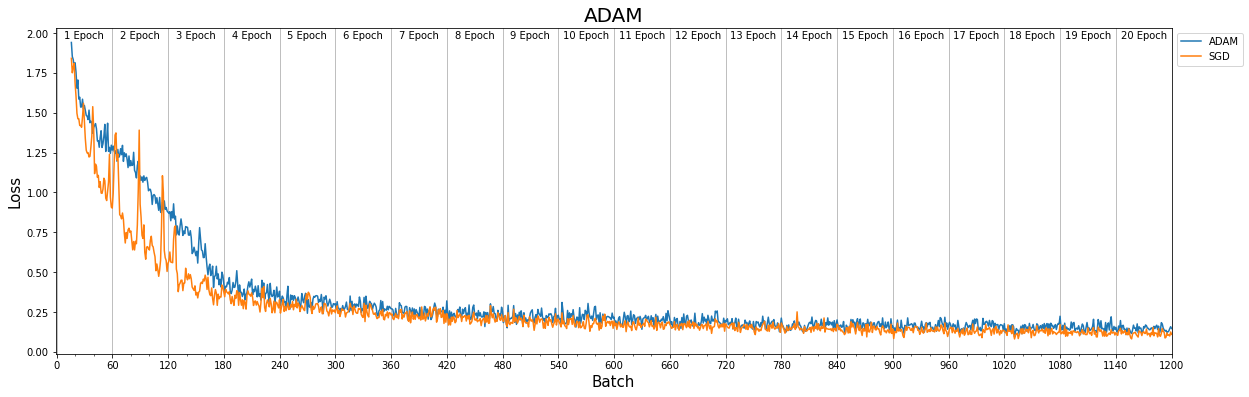

In [15]:
# SGD와 비교 loss비교
import pickle

with open('../../pickle_folder/SGD.pickle', 'rb') as f:
    sgd_loss_list =  pickle.load(f)

major_xticks = range(0, len(train_loss_list)+1, 60)
minor_xticks = range(20, len(train_loss_list)+1, 20)

fig, ax = plt.subplots(figsize=(20, 6))

ax.set_xlim([-1, 1200])

ax.set_xlabel('Batch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_title('ADAM', fontsize=20)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)

ax.plot(range(16, 16+len(train_loss_list[15:])), train_loss_list[15:], label='ADAM') # 처음 부터 그리면 초반 5개 정도는 loss 값이 급격하게 낮아지므로 변화량을 제대로 확인하기 어렵다.
ax.plot(range(16, 16+len(train_loss_list[15:])), sgd_loss_list[15:], label='SGD')

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax.grid(axis='x')

for line_idx in range(0, len(train_loss_list), 60):
    ax.text((line_idx*2 + 60)/2, ax.get_ylim()[1] - ax.get_ylim()[1]/100, 
           s=str(int(line_idx/60)+1) + ' Epoch',
           va='top', ha='center')

plt.show()


## Test

In [16]:
test_data = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
testloader = DataLoader(test_data, batch_size=5000, shuffle=False)

In [17]:
with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (x_test_batch, y_test_batch) in enumerate(testloader):
        test_images = x_test_batch.to(device)
        test_labels = y_test_batch.to(device)
        test_labels_long = torch.tensor(test_labels, dtype=torch.long)
        
        prediction_softmax = F.softmax(model(test_images), dim=1)
        prediction_class = torch.argmax(prediction_softmax, dim=1)
        
        correct += (prediction_class == test_labels_long).sum().item()
        num_total_data += len(test_images)

print(f"ADAM이용한 모델의 정확도: {correct/num_total_data*100:.2f}%") 

ADAM이용한 모델의 정확도: 94.82%
